In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from libary import *
from recurrent import *
from ARMA import *

In [2]:
train_ratio = 0.5
valid_ratio = 0.25

# Select frequency
frequencies = ['min','5min','15min','60min','D']
frequencies_number_of_samples = np.multiply([390,78,26,7,1],252)

Frequency: D
ARMA
Period: 0, order: [0. 0.], mse: [4.61537205e-04 9.17540686e-05]
Period: 1, order: [1. 0.], mse: [1.69159138e-04 6.97803931e-05]
Period: 2, order: [0. 0.], mse: [8.54570920e-05 2.47004967e-04]
Period: 3, order: [1. 0.], mse: [1.21962137e-04 5.64653159e-05]
Period: 4, order: [0. 0.], mse: [5.47238238e-05 2.93307003e-05]
Period: 5, order: [0. 0.], mse: [3.65947036e-05 5.76563209e-05]
Period: 6, order: [1. 0.], mse: [4.28818112e-05 1.25444773e-04]
Period: 7, order: [0. 0.], mse: [7.62030212e-05 2.42941148e-05]
ARMA training time: 0.03 minutes
LSTM
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.000304 |  5.659    |  0.4983   |  37.28    |  0.7589   |  3.699    |  1.302    |  1.689    |
|  2        | -0.000304 |  9.48     |  0.1723   |  25.05    |  0.6753   |  34.89    |  2.134

|  2        | -6e-05    |  7.19     |  0.09021  |  13.49    |  0.8936   |  15.58    |  1.051    |  0.07394  |
Period time: 0.26 minutes
Period: 3
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -6.212e-0 |  9.904    |  0.2032   |  19.94    |  0.8154   |  38.2     |  2.23     |  1.771    |
|  2        | -6.34e-05 |  9.363    |  0.003478 |  1.436    |  0.9145   |  23.97    |  3.011    |  0.1737   |
Period time: 0.2 minutes
Period: 4
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -4.405e-0 |  8.465    |  0.06913  |  15.94    |  0.9708   |  8.416    |  3.83     |  1.187    |
|  2        | -4.408e-0 |  6.257    |  0.443    |

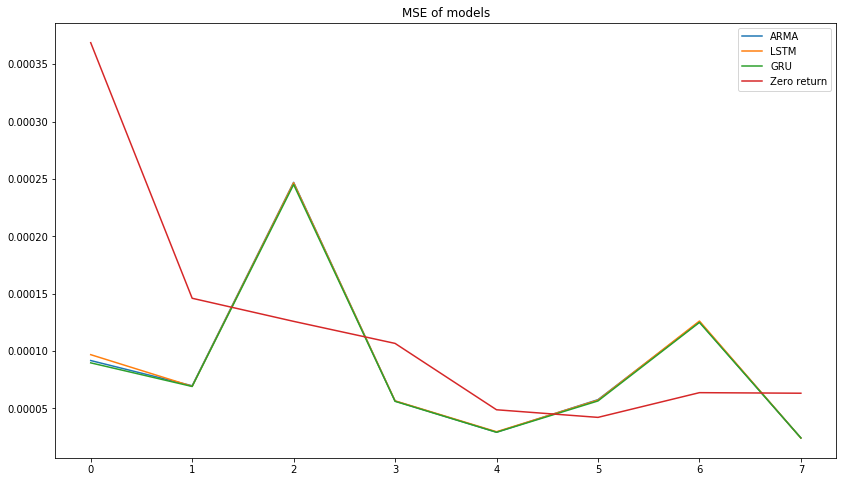

Frequency: 60min
ARMA
Period: 0, order: [0. 0.], mse: [6.80038215e-05 1.30250384e-05]
Period: 1, order: [0. 1.], mse: [2.80610000e-05 1.13157298e-05]
Period: 2, order: [0. 1.], mse: [1.28548667e-05 3.52981401e-05]
Period: 3, order: [2. 2.], mse: [1.71800408e-05 3.03203515e-05]
Period: 4, order: [2. 0.], mse: [6.88634094e-06 4.39181715e-06]
Period: 5, order: [1. 0.], mse: [5.10796232e-06 7.31129258e-06]
Period: 6, order: [1. 0.], mse: [5.88566391e-06 1.77769376e-05]
Period: 7, order: [1. 1.], mse: [1.06141682e-05 4.49135162e-06]
ARMA training time: 0.25 minutes
LSTM
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -5.26e-05 |  5.0      |  0.3334   |  5.296    |  0.6569   |  21.02    |  2.349    |  1.301    |
|  2        | -5.257e-0 |  9.822    |  0.0648   |  38.95    |  0.9387   |  2.326    |  1

|  2        | -8.486e-0 |  6.72     |  0.4422   |  36.39    |  0.8182   |  8.791    |  2.559    |  1.27     |
Period time: 0.9 minutes
Period: 3
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -8.322e-0 |  7.417    |  0.1285   |  11.5     |  0.4715   |  32.31    |  3.648    |  1.014    |
|  2        | -8.322e-0 |  9.917    |  0.482    |  31.77    |  0.9991   |  31.43    |  3.02     |  0.2816   |
Period time: 0.75 minutes
Period: 4
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -6.095e-0 |  9.392    |  0.4536   |  34.06    |  0.5115   |  23.94    |  1.475    |  1.246    |
|  2        | -6.122e-0 |  5.63     |  0.05545  |

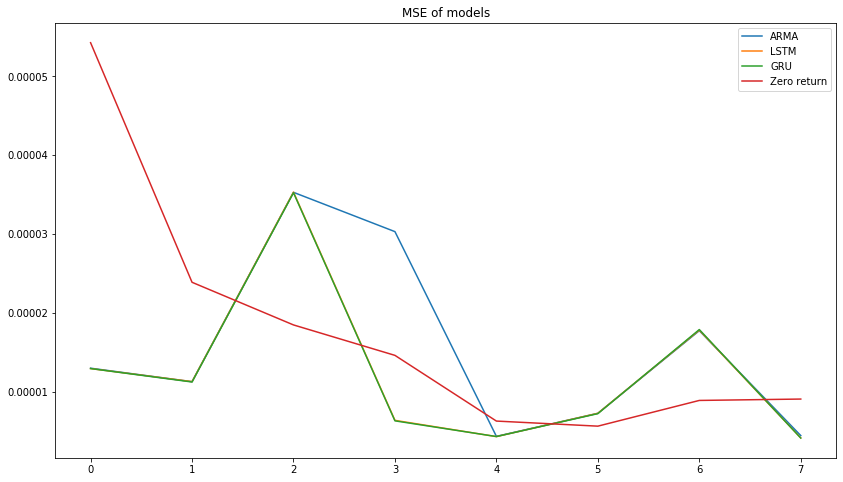

Frequency: 15min
ARMA
Period: 0, order: [5. 4.], mse: [1.66328642e-05 2.10545490e-05]
Period: 1, order: [0. 2.], mse: [8.19202184e-06 2.92180520e-06]
Period: 2, order: [0. 3.], mse: [3.97935661e-06 8.72592617e-06]
Period: 3, order: [1. 0.], mse: [4.41679240e-06 1.78894295e-06]
Period: 4, order: [1. 0.], mse: [1.86458621e-06 1.18127333e-06]
Period: 5, order: [0. 1.], mse: [1.35852385e-06 2.06502225e-06]
Period: 6, order: [1. 1.], mse: [1.62337843e-06 6.30449416e-06]
Period: 7, order: [2. 2.], mse: [2.85386240e-06 2.10946157e-06]
ARMA training time: 2.01 minutes
LSTM
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.444e-0 |  5.475    |  0.1827   |  4.986    |  0.4012   |  29.04    |  3.379    |  1.333    |
|  2        | -1.445e-0 |  5.209    |  0.1048   |  30.89    |  0.5907   |  20.21    |  1

|  2        | -2.458e-0 |  5.745    |  0.1922   |  18.35    |  0.7345   |  29.39    |  3.158    |  1.455    |
Period time: 3.14 minutes
Period: 3
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -2.164e-0 |  9.307    |  0.1071   |  18.64    |  0.621    |  16.12    |  2.817    |  0.4848   |
|  2        | -2.16e-06 |  5.041    |  0.02736  |  35.84    |  0.9308   |  31.64    |  2.791    |  0.829    |
Period time: 3.67 minutes
Period: 4
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.641e-0 |  7.401    |  0.3687   |  31.35    |  0.3761   |  11.44    |  1.862    |  1.313    |
|  2        | -1.646e-0 |  9.07     |  0.4364   

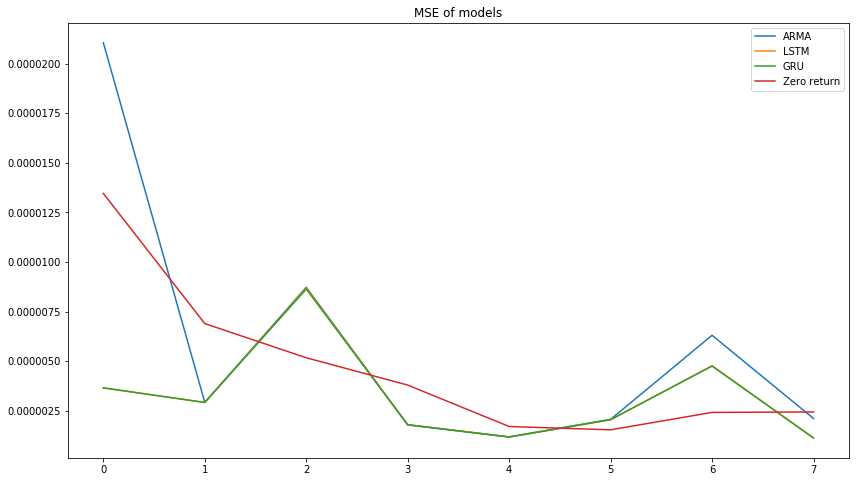

Frequency: 5min
ARMA
Period: 0, order: [1. 1.], mse: [5.75048510e-06 1.41485167e-06]
Period: 1, order: [1. 1.], mse: [2.67247612e-06 1.09827957e-06]
Period: 2, order: [4. 3.], mse: [1.25434406e-06 7.95877416e-06]
Period: 3, order: [1. 2.], mse: [1.52338963e-06 2.70061474e-06]
Period: 4, order: [1. 1.], mse: [6.12202194e-07 4.09615372e-07]
Period: 5, order: [4. 2.], mse: [4.53252455e-07 1.71123624e-06]
Period: 6, order: [1. 1.], mse: [5.30060711e-07 1.83062429e-06]
Period: 7, order: [0. 5.], mse: [9.27508274e-07 3.65191200e-07]
ARMA training time: 8.66 minutes
LSTM
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -4.798e-0 |  7.673    |  0.2508   |  35.13    |  0.8295   |  2.597    |  2.805    |  1.849    |
|  2        | -4.785e-0 |  7.19     |  0.1306   |  14.69    |  0.6512   |  6.367    |  2.

|  1        | -8.306e-0 |  9.888    |  0.1965   |  5.192    |  0.897    |  9.347    |  1.62     |  0.6079   |
|  2        | -8.292e-0 |  4.722    |  0.3352   |  34.18    |  0.6338   |  26.93    |  3.188    |  1.192    |
Period time: 9.57 minutes
Period: 3
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -7.155e-0 |  4.072    |  0.1765   |  7.438    |  0.567    |  12.58    |  1.609    |  1.237    |
|  2        | -7.241e-0 |  9.415    |  0.2904   |  7.838    |  0.9795   |  35.5     |  2.546    |  0.7679   |
Period time: 3.45 minutes
Period: 4
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -5.412e-0 |  5.322    |  0.4304   

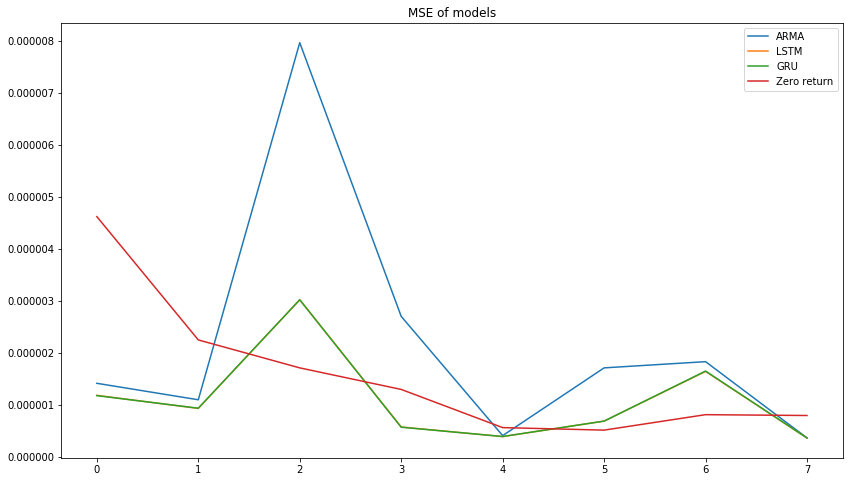

Frequency: min
ARMA
Period: 0, order: [2. 0.], mse: [1.03904353e-06 2.28883946e-07]
Period: 1, order: [2. 0.], mse: [4.80926927e-07 1.70483453e-07]
Period: 2, order: [4. 3.], mse: [2.18947564e-07 8.18787933e-07]
Period: 3, order: [2. 0.], mse: [2.82538584e-07 1.04457048e-07]
Period: 4, order: [2. 0.], mse: [1.12297612e-07 6.99672674e-08]
Period: 5, order: [2. 0.], mse: [8.04348281e-08 1.23473187e-07]
Period: 6, order: [2. 0.], mse: [9.41022563e-08 3.02611821e-07]
Period: 7, order: [5. 2.], mse: [1.69101916e-07 2.23564065e-07]
ARMA training time: 70.35 minutes
LSTM
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -8.807e-0 |  6.64     |  0.3966   |  38.69    |  0.4137   |  8.615    |  1.34     |  0.2826   |
|  2        | -8.785e-0 |  5.968    |  0.1138   |  19.23    |  0.8627   |  33.94    |  1.

|  2        | -1.529e-0 |  8.691    |  0.02958  |  1.909    |  0.3045   |  38.98    |  1.901    |  0.8868   |
Period time: 39.87 minutes
Period: 3
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.343e-0 |  7.713    |  0.09297  |  10.92    |  0.6637   |  28.92    |  1.057    |  0.645    |
|  2        | -1.341e-0 |  5.574    |  0.07627  |  24.19    |  0.3102   |  19.32    |  2.614    |  1.304    |
Period time: 42.22 minutes
Period: 4
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        | -9.87e-08 |  4.77     |  0.1355   |  17.88    |  0.5056   |  22.78    |  2.018    |  1.446    |
|  2        | -9.781e-0 |  7.411    |  0.4617 

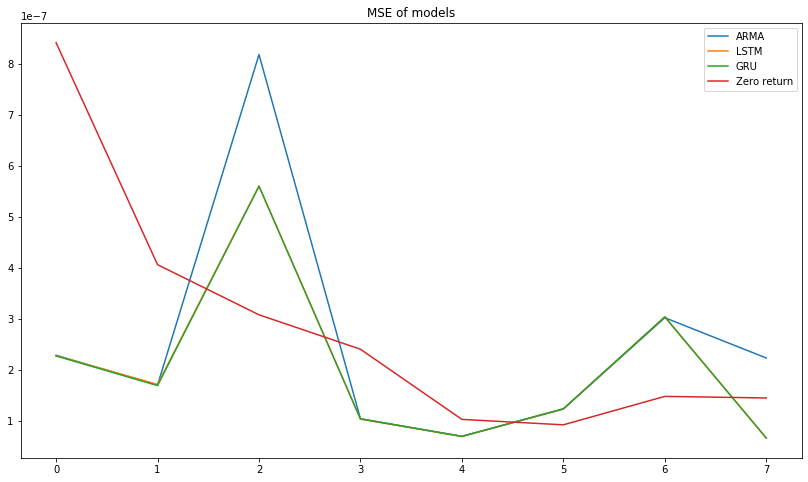

In [3]:
for frequency_index in range(4, -1, -1):
    print(f'Frequency: {frequencies[frequency_index]}')
    number_of_study_periods, study_periods, Data, dates = creating_study_periods(frequencies,\
                                                                                 frequencies_number_of_samples,\
                                                                                 frequency_index)
    # visualize_data(Data, Returns)
    
    print('ARMA')
    ARMA_parameters, ARMA_mse, ARMA_predictions = train_ARMA(number_of_study_periods, study_periods,\
                                                             train_ratio, valid_ratio,\
                                                             frequency_index, frequencies, frequencies_number_of_samples)
    
    print('LSTM')
    LSTM_names, LSTM_mse, LSTM_predictions = train_recurrent_model('LSTM', number_of_study_periods ,study_periods,\
                                                             train_ratio, valid_ratio,\
                                                             frequency_index, frequencies, frequencies_number_of_samples)
    print('GRU')
    GRU_names, GRU_mse, GRU_predictions = train_recurrent_model('GRU', number_of_study_periods, study_periods,\
                                                             train_ratio, valid_ratio,\
                                                             frequency_index, frequencies, frequencies_number_of_samples)
    
    
    
    visualize_results((np.concatenate((np.reshape(ARMA_mse[:,-1], [number_of_study_periods,1]),\
                          np.reshape(LSTM_mse[:,-1], [number_of_study_periods,1]),\
                          np.reshape(GRU_mse[:,-1], [number_of_study_periods,1]),\
                          np.reshape(np.mean(np.square(study_periods[0,:,-ARMA_predictions.shape[1]:]),axis=1),\
                                                         [number_of_study_periods,1])), axis=1)))

In [4]:
model_names = ['ARMA', 'LSTM', 'GRU']

for frequency_index in range(4, -1, -1):
    print(f'Frequency: {frequencies[frequency_index]}')
    number_of_study_periods, study_periods, Data, dates = creating_study_periods(frequencies,\
                                                                                 frequencies_number_of_samples,\
                                                                                 frequency_index)
    study_periods_direction = study_periods[0]
    study_periods_direction[0<study_periods_direction] = 1
    study_periods_direction[0==study_periods_direction] = 0
    study_periods_direction[0>study_periods_direction] = -1
    
    train_size = np.round(np.size(study_periods[0], 1) * train_ratio).astype(int)
    valid_size = np.round(np.size(study_periods[0], 1) * valid_ratio).astype(int)
    test_size = (np.size(study_periods[0], 1) - train_size - valid_size).astype(int)
    
    predictions = np.zeros((3,number_of_study_periods,test_size))
    for model_index in range(3):
        print(model_names[model_index])
        predictions[model_index] = pd.read_csv('results/'+str(model_names[model_index])+'_predictions_frequency_'\
                                         +str(frequencies[frequency_index])+'.csv', header=None).dropna(axis='columns').values
print(predictions)

Frequency: D
ARMA
LSTM
GRU
Frequency: 60min
ARMA
LSTM
GRU
Frequency: 15min
ARMA
LSTM
GRU
Frequency: 5min
ARMA
LSTM
GRU
Frequency: min
ARMA
LSTM
GRU
[[[-3.94770525e-06  3.33775900e-06  5.49627055e-05 ... -1.22120688e-05
    3.66251429e-05 -7.12398095e-06]
  [-5.09625304e-05  3.32082169e-05  3.42133928e-06 ... -3.48955612e-07
   -2.07237831e-06 -4.14340286e-07]
  [-7.00697359e-07  2.13642770e-04  3.51194526e-04 ...  3.12728821e-04
    3.51840127e-04  3.52931270e-04]
  ...
  [-7.09211259e-05  1.40396751e-05 -9.61712860e-06 ... -1.82599907e-06
    1.68515862e-05  1.68215510e-05]
  [-2.42991829e-05 -5.44508244e-05 -9.64187391e-05 ...  1.12491492e-04
   -2.99062013e-05 -1.73334297e-05]
  [ 1.23363624e-05 -1.10355819e-04  2.46069706e-05 ... -1.75977278e-04
    1.60371611e-04  3.43351645e-04]]

 [[-5.13887244e-07 -3.92048350e-05 -3.38808386e-05 ...  1.71461761e-05
    9.07940994e-05  7.86731289e-06]
  [-4.84156881e-05 -1.24726430e-05 -1.78122300e-05 ... -3.66576169e-05
   -3.35590921e-05 -3.20

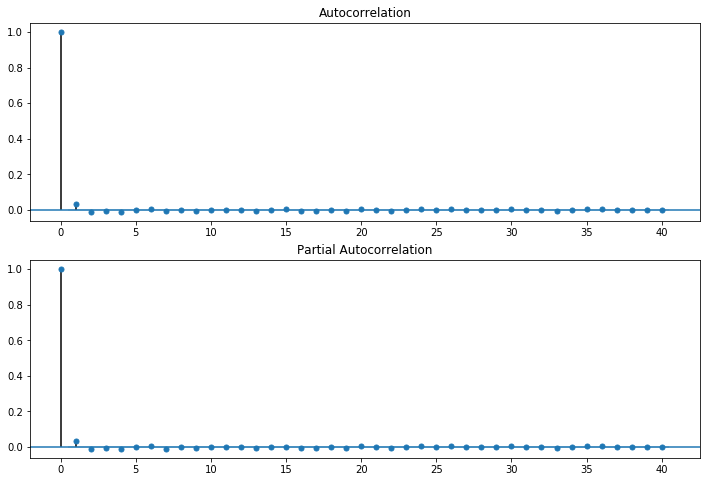

In [5]:
import statsmodels.api as sm
i = 7
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(study_periods[0,i], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(study_periods[0,i], lags=40, ax=ax2)# , lags=40